In [2]:
import pandas as pd

In [3]:
data=pd.read_csv('../data/impression_log.csv',index_col=0)

In [3]:
sum=data.groupby(["CampaignId","Site"],as_index=False).agg("sum")
count=data.groupby(["CampaignId","Site"],as_index=False).agg("count")

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 00006a06-14e2-47d9-b999-fbeeac67dd2b to 6404d38e-1669-4e0e-b6a4-dab8dc454f45
Data columns (total 23 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   LogEntryTime        100000 non-null  object 
 1   AdvertiserId        100000 non-null  object 
 2   CampaignId          100000 non-null  object 
 3   AdGroupId           100000 non-null  object 
 4   AudienceID          96546 non-null   object 
 5   CreativeId          100000 non-null  object 
 6   AdFormat            100000 non-null  object 
 7   Frequency           100000 non-null  int64  
 8   Site                100000 non-null  object 
 9   FoldPosition        100000 non-null  int64  
 10  Country             100000 non-null  object 
 11  Region              99999 non-null   object 
 12  City                99999 non-null   object 
 13  DeviceType          100000 non-null  int64  
 14  OSFamily            9999

In [4]:
import plotly.express as px
fig = px.scatter(x=sum["engagement"], y=count["engagement"], color=sum["engagement"]/count["engagement"])
fig.show()

In [9]:
counts=data.groupby("engagement").size().reset_index(name="counts")

In [10]:
fig = px.bar(counts,x="engagement",y="counts")
# fig.update_xaxes(type='Engagement')
fig.show()

In [18]:
counts=data.groupby(["click","engagement"],as_index=False).size()
fig = px.bar(counts,x="click",y="size",color="engagement")
fig.show()

In [ ]:
data_aggregated["engagement_index"]=sum["engagement"]/count["engagement"]

In [20]:
aggregated_data=data.groupby(["CampaignId","Site"],as_index=False).agg(TotalEngagement=pd.NamedAgg(column='engagement', aggfunc='sum'), Impressions=pd.NamedAgg(column='engagement', aggfunc='count'),TotalClicks=pd.NamedAgg(column='click', aggfunc='sum'))

In [21]:
aggregated_data

,CampaignId,Site,TotalEngagement,Impressions,TotalClicks
0,0k2sw7w,247sports.com,0,1,0
1,0k2sw7w,arealnews.com,0,1,0
2,0k2sw7w,blackdoctor.org,0,1,0
3,0k2sw7w,comicbook.com,0,2,0
4,0k2sw7w,dailyvoice.com,0,2,0
...,...,...,...,...,...
19977,z5cjizq,www.wordplays.com,0,6,0
19978,z5cjizq,www.wral.com,0,2,0
19979,z5cjizq,www.wsbtv.com,0,1,0
19980,z5cjizq,www.yahoo.com,2,78,2


In [34]:
aggregated_data["CampaignId"].unique()

array(['0k2sw7w', '5qtwg2a', '758ifo0', '8muucqy', '9n6o7jf', 'awbu4q4',
       'dnpjc6c', 'fiwemi8', 'shg01yl', 't29si1w', 'v0fbymt', 'xygdmea',
       'z5cjizq'], dtype=object)

In [24]:
def score(row):
    final_score=(row["TotalEngagement"]+1)/(row["Impressions"]+2)
    return final_score

In [37]:
def sortWebsites(CampaignId,dataframe):
    rslt_df = dataframe[dataframe['CampaignId']==CampaignId]
    rslt_df=rslt_df.copy()
    rslt_df["score"]=rslt_df.apply(score, axis=1)
    rslt_df=rslt_df.sort_values("score",ascending=False)
    return rslt_df

In [39]:
sortWebsites("awbu4q4",aggregated_data)

,CampaignId,Site,TotalEngagement,Impressions,TotalClicks,score
7259,awbu4q4,www.movieinsider.com,3,3,2,0.800000
6347,awbu4q4,wheretheroadforks.com,3,3,0,0.800000
6178,awbu4q4,theyardandgarden.com,2,2,1,0.750000
6608,awbu4q4,www.cosmopolitan.com,2,2,0,0.750000
5721,awbu4q4,pomeranian.org,2,2,0,0.750000
...,...,...,...,...,...,...
7971,awbu4q4,www.wordplays.com,0,47,0,0.020408
7711,awbu4q4,www.thedailybeast.com,1,100,0,0.019608
4673,awbu4q4,belleofthekitchen.com,0,51,0,0.018868
7356,awbu4q4,www.ondemandkorea.com,1,145,0,0.013605


In [26]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.compose import ColumnTransformer

In [4]:
decsisive_data=data[["AdFormat", "FoldPosition", "OS", "DeviceType","engagement"]].copy()

In [12]:
decsisive_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99993 entries, 00006a06-14e2-47d9-b999-fbeeac67dd2b to 6404d38e-1669-4e0e-b6a4-dab8dc454f45
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   AdFormat      99993 non-null  object 
 1   FoldPosition  99993 non-null  int64  
 2   OS            99993 non-null  float64
 3   DeviceType    99993 non-null  int64  
 4   engagement    99993 non-null  int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 4.6+ MB


In [17]:
decsisive_data["OS"].unique()

array([173., 156., 101., 162., 174., 167., 155., 169., 175., 141., 145.,
       154.,   0., 172., 140., 171., 139., 166., 168., 165., 153., 150.,
       136., 144., 112., 161., 170., 163., 164., 159., 160., 148., 157.,
       151., 152., 111., 143., 110., 149., 146., 107., 108., 158., 109.,
       147., 114., 137., 138., 113.])

In [5]:
decsisive_data.dropna(inplace=True)

In [6]:

from sklearn.preprocessing import OneHotEncoder
encoder=OneHotEncoder(handle_unknown='ignore')

In [36]:
len(encoder.get_feature_names(features.columns.to_list()))

57

In [41]:
encoded_features.shape

(99993, 57)

In [43]:
encoder.get_feature_names(features.columns.to_list())

array(['AdFormat_300x250', 'AdFormat_320x480', 'FoldPosition_2',
       'FoldPosition_3', 'FoldPosition_4', 'OS_0.0', 'OS_101.0',
       'OS_107.0', 'OS_108.0', 'OS_109.0', 'OS_110.0', 'OS_111.0',
       'OS_112.0', 'OS_113.0', 'OS_114.0', 'OS_136.0', 'OS_137.0',
       'OS_138.0', 'OS_139.0', 'OS_140.0', 'OS_141.0', 'OS_143.0',
       'OS_144.0', 'OS_145.0', 'OS_146.0', 'OS_147.0', 'OS_148.0',
       'OS_149.0', 'OS_150.0', 'OS_151.0', 'OS_152.0', 'OS_153.0',
       'OS_154.0', 'OS_155.0', 'OS_156.0', 'OS_157.0', 'OS_158.0',
       'OS_159.0', 'OS_160.0', 'OS_161.0', 'OS_162.0', 'OS_163.0',
       'OS_164.0', 'OS_165.0', 'OS_166.0', 'OS_167.0', 'OS_168.0',
       'OS_169.0', 'OS_170.0', 'OS_171.0', 'OS_172.0', 'OS_173.0',
       'OS_174.0', 'OS_175.0', 'DeviceType_1', 'DeviceType_3',
       'DeviceType_4'], dtype=object)

In [7]:
features=decsisive_data.copy().drop("engagement",axis=1,inplace=False)

encoded_features=encoder.fit_transform(features)
y=decsisive_data["engagement"]


In [8]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test=train_test_split(encoded_features,y,test_size=0.3)

In [9]:
import numpy as np

In [10]:

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV
import numpy as np
import mlflow

param_grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}

mlflow.sklearn.autolog()

with mlflow.start_run(run_name="LogisticRegression"):
    logreg=LogisticRegression()
    logreg_cv=GridSearchCV(logreg,param_grid,cv=10)
    logreg_cv.fit(x_train,y_train)

    print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
    print("accuracy :",logreg_cv.best_score_)
mlflow.end_run()

2021/09/30 17:32:23 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
C:\Users\same\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\same\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterat

tuned hpyerparameters :(best parameters)  {'C': 0.001, 'penalty': 'l2'}
accuracy : 0.8708336313350887


In [17]:
logreg_cv.best_estimator_.coef_

array([[-2.73844794e-01,  2.73774872e-01, -9.97375440e-02,
         3.90137407e-02,  6.06538809e-02, -9.84337652e-03,
        -1.55541777e-02,  1.92501393e-03, -1.36117091e-04,
        -3.10121805e-04, -1.72714610e-04, -3.34338957e-03,
        -1.66461519e-03, -7.31427807e-05,  0.00000000e+00,
        -8.57632466e-03, -7.31427807e-05,  0.00000000e+00,
        -8.00757339e-03, -3.60807830e-03, -1.26830876e-02,
        -1.46274673e-04, -4.02522826e-03,  4.82328965e-04,
        -6.45670284e-04, -2.35676272e-04, -1.69676564e-03,
        -1.10218182e-03, -1.16180059e-03,  3.37726912e-04,
         4.83827754e-04,  1.90901148e-04, -3.79687568e-02,
         3.82316680e-03, -4.53743569e-03, -7.36465820e-03,
         6.41304936e-04, -2.17172902e-03, -4.05329643e-05,
        -2.90648551e-03,  1.44931792e-01,  1.24951556e-04,
        -5.16394545e-03, -1.48419815e-03, -4.56762988e-03,
         3.22148305e-03,  9.52066793e-03,  3.41456265e-04,
        -4.81458845e-04,  6.34313031e-04, -2.09623816e-0

In [21]:
feature_importances=pd.DataFrame((logreg_cv.best_estimator_.coef_).transpose() , index=encoder.get_feature_names_out(features.columns.to_list()), columns=['importance'])
feature_importances.sort_values('importance',key=abs, ascending=False)

,importance
AdFormat_300x250,-0.273845
AdFormat_320x480,0.273775
DeviceType_4,0.244918
DeviceType_3,-0.241807
OS_162.0,0.144932
FoldPosition_2,-0.099738
FoldPosition_4,0.060654
FoldPosition_3,0.039014
OS_154.0,-0.037969
OS_174.0,-0.033619


In [38]:
X=pd.get_dummies(decsisive_data.sample(n=1000, random_state=1),columns=["AdFormat", "FoldPosition", "OS", "DeviceType"])
y=X["engagement"]
X=X.drop("engagement",axis=1,inplace=False)
columns=X.columns.to_list()

C:\Users\same\AppData\Roaming\Python\Python38\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\same\AppData\Roaming\Python\Python38\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\same\AppData\Roaming\Python\Python38\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\same\AppData\Roaming\Python\Python38\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\same\AppData\Roaming\Python\Python38\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


MEAN Score: 0.815
MEAN EFFECT DIRECTIONAL CLASS 0:
OS_153.0            0.241674
OS_162.0            0.229774
DeviceType_4        0.220259
OS_155.0            0.151697
AdFormat_320x480    0.142020
OS_139.0            0.135912
OS_173.0            0.079382
OS_140.0            0.076132
OS_175.0            0.042244
FoldPosition_2      0.038240
OS_171.0            0.033266
OS_156.0            0.008174
OS_164.0           -0.000088
OS_112.0           -0.000103
OS_141.0           -0.005963
OS_0.0             -0.006017
OS_145.0           -0.026178
OS_169.0           -0.033701
OS_101.0           -0.047797
OS_144.0           -0.052557
OS_168.0           -0.059772
OS_150.0           -0.069845
OS_163.0           -0.076233
OS_174.0           -0.089646
OS_161.0           -0.090940
OS_166.0           -0.095033
OS_172.0           -0.096811
OS_136.0           -0.101825
OS_165.0           -0.115266
OS_170.0           -0.115523
OS_167.0           -0.118275
FoldPosition_3     -0.125766
AdFormat_300x250   -0

D:\Users\same\anaconda3\lib\site-packages\pygraphviz\agraph.py:1367: RuntimeWarning: Warning: node 'AdFormat_300x250', graph '' size too small for label
0.03:#ffffff9e;0.03:#ffffffa2;0.03:#ffffffa6;0.03:#ffffffaa;0.03" color attribute; float expected after ';'
in edge AdFormat_300x250 -> AdFormat_320x480

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


(<Figure size 1248.48x1178.64 with 1 Axes>, <AxesSubplot:>)

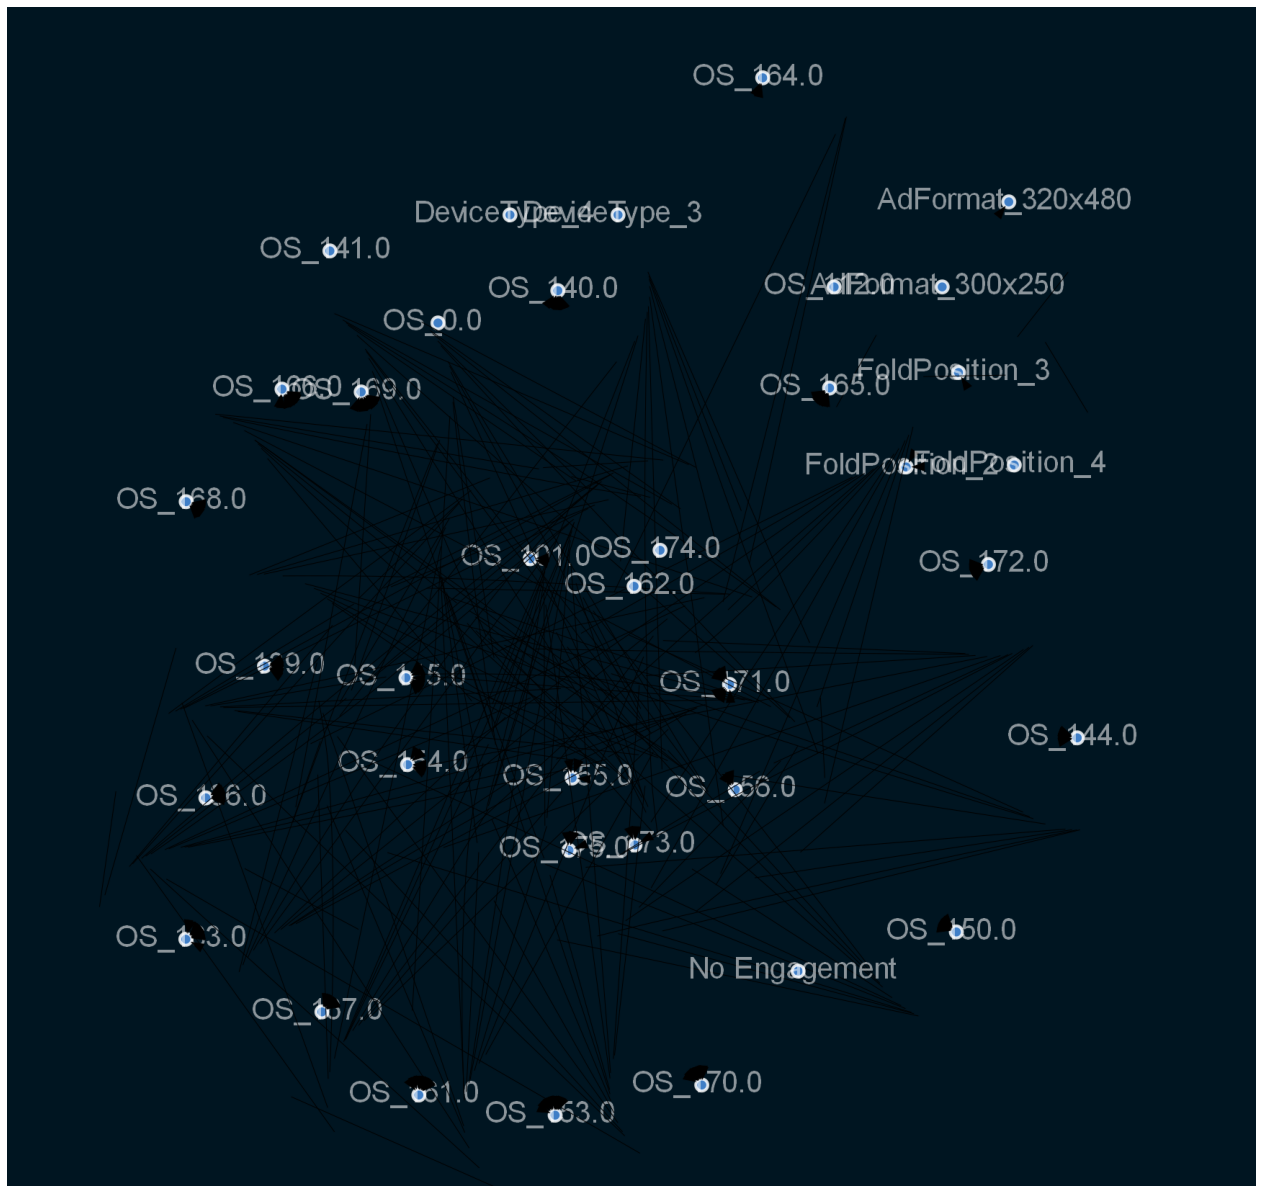

In [40]:
from causalnex.structure import DAGClassifier
clf = DAGClassifier(
    alpha=0.1,
    beta=0.9,
    hidden_layer_units=[5],
    fit_intercept=True,
    standardize=True
)
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
scores = cross_val_score(clf, X, y, cv=KFold(shuffle=True, random_state=42))
print(f'MEAN Score: {np.mean(scores).mean():.3f}')

y = pd.Series(y, name="No Engagement")
clf.fit(X, y)
for i in range(clf.coef_.shape[0]):
    print("MEAN EFFECT DIRECTIONAL CLASS {}:".format(i))
    print(pd.Series(clf.coef_[i, :], index=columns).sort_values(key=abs,ascending=False))
clf.plot_dag(True)